In [61]:
import os
import sys
import random
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log
import skimage
%load_ext autoreload
%autoreload 2
    
%matplotlib inline 

# Root directory of the project
ROOT_DIR = '/data1/share/shiky/Mask_RCNN/data'
ROOT_DIR2 = '/data1/share/shiky/Mask_RCNN'
img_train = os.path.join(ROOT_DIR, 'train', 'images') 
img_val = os.path.join(ROOT_DIR, 'validation', 'images') 

mask_train = os.path.join(ROOT_DIR, 'train', 'masks') 
mask_val = os.path.join(ROOT_DIR, 'validation', 'masks') 


train_imglist = os.listdir(img_train)
val_imglist = os.listdir(img_val)

train_count = len(train_imglist)
val_count = len(val_imglist)
# width = 1280
# height = 800
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR2, "mask_rcnn_coco.h5")


/root/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [62]:
class CalConfig(Config):
    """Configuration for calcifications detection project, which is derived from standard mask rcnn config class"""
    
    # Give the configuration a recognizable name
    NAME = "cal"
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    
    LEARNING_RATE   = 0.001
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 512)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 700

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = CalConfig()
config.display()   



Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  1024
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           cal
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING      

In [63]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [64]:
class CalDataset(utils.Dataset):
    """Create customized dataset class to load data"""
    def load_cal(self,count, data_dir, mask_dir, namelist):
        """load """
        
        #Add classes
        self.add_class("breast", 1, "calcification" )
        
        #Add images
        
        for i in range(count):
            src = namelist[i]
            
            name = src.split('_')
            full_name = '_'.join(name[0:4])
            mask_middle= full_name.split('.')[0]
            mask_name = mask_middle + '_MASK.jpg'
            mask_path = os.path.join(mask_dir, mask_name)
            
            self.add_image("breast", image_id = i, path = os.path.join(data_dir, full_name), mask_path = mask_path , full_name =full_name)
#     def load_image(self, image_id):
#         """load image from local path"""
        
#         info = self.image_info[image_id]
       
#         image = skimage.io.imread(info.path)
        
#         return image
        
    def load_mask(self, image_id):
        """load the mask image"""
        
        info = self.image_info[image_id]
        
       
        mask = skimage.io.imread(info['mask_path']).astype(bool)
        mask = mask[:,:,np.newaxis]
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index("calcification")])
        
        return mask, class_ids.astype(np.int32)
        
    def load_name(self, image_id):
        """load the image name"""
        info = self.image_info[image_id]
        
        return info['full_name']
        

In [65]:
# Training dataset
dataset_train = CalDataset()
dataset_train.load_cal(753, img_train, mask_train, train_imglist)
dataset_train.prepare()

# Validation dataset
dataset_val = CalDataset()
dataset_val.load_cal(200, img_val, mask_val, val_imglist)
dataset_val.prepare()

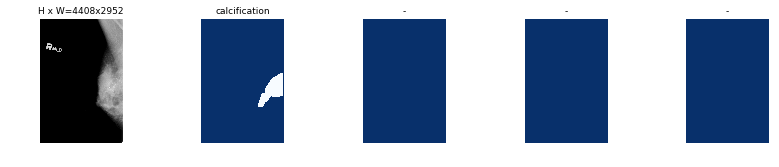

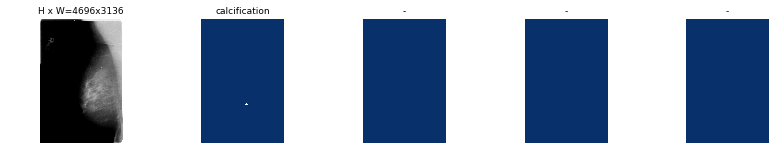

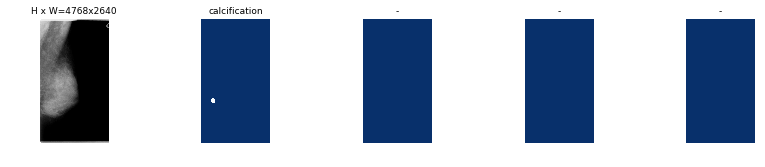

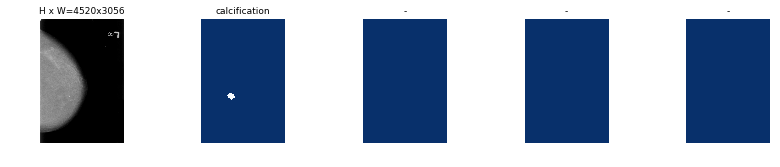

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [66]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [67]:
# Load the last model you trained and continue training
# model.load_weights(COCO_MODEL_PATH, by_name=True,
#                        exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
#                                 "mrcnn_bbox", "mrcnn_mask"])
model_path = model.find_last()[1]
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"

print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Loading weights from  /data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0020.h5


In [39]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcn

/root/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/root/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/root/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/20
700/700 [==============================] - 361s 516ms/step - loss: 4.7542 - rpn_class_loss: 0.0902 - rpn_bbox_loss: 2.9818 - mrcnn_class_loss: 0.1413 - mrcnn_bbox_loss: 1.1510 - mrcnn_mask_loss: 0.3898 - val_loss: 4.0292 - val_rpn_class_loss: 0.0952 - val_rpn_bbox_loss: 0.8617 - val_mrcnn_class_loss: 0.2809 - val_mrcnn_bbox_loss: 2.1307 - val_mrcnn_mask_loss: 0.6607
Epoch 2/20
700/700 [==============================] - 356s 508ms/step - loss: 2.1304 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 0.9701 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.6392 - mrcnn_mask_loss: 0.4275 - val_loss: 0.4512 - val_rpn_class_loss: 0.0204 - val_rpn_bbox_loss: 0.4308 - val_mrcnn_class_loss: 0.0000e+00 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 3/20
700/700 [==============================] - 354s 506ms/step - loss: 1.7534 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.7014 - mrcnn_class_loss: 0.0933 - mrcnn_bbox_loss: 0.5247 - mrcnn_mask_loss: 0.4106 - val_loss: 0.4

In [68]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=40, 
            layers="all")


Starting at epoch 21. LR=0.0001

Checkpoint Path: /data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn

/root/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/root/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/root/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


bn4t_branch2a          (BatchNorm)
res4t_branch2b         (Conv2D)
bn4t_branch2b          (BatchNorm)
res4t_branch2c         (Conv2D)
bn4t_branch2c          (BatchNorm)
res4u_branch2a         (Conv2D)
bn4u_branch2a          (BatchNorm)
res4u_branch2b         (Conv2D)
bn4u_branch2b          (BatchNorm)
res4u_branch2c         (Conv2D)
bn4u_branch2c          (BatchNorm)
res4v_branch2a         (Conv2D)
bn4v_branch2a          (BatchNorm)
res4v_branch2b         (Conv2D)
bn4v_branch2b          (BatchNorm)
res4v_branch2c         (Conv2D)
bn4v_branch2c          (BatchNorm)
res4w_branch2a         (Conv2D)
bn4w_branch2a          (BatchNorm)
res4w_branch2b         (Conv2D)
bn4w_branch2b          (BatchNorm)
res4w_branch2c         (Conv2D)
bn4w_branch2c          (BatchNorm)
res5a_branch2a         (Conv2D)
bn5a_branch2a          (BatchNorm)
res5a_branch2b         (Conv2D)
bn5a_branch2b          (BatchNorm)
res5a_branch2c         (Conv2D)
res5a_branch1          (Conv2D)
bn5a_branch2c          (BatchN

Epoch 37/40
700/700 [==============================] - 578s 826ms/step - loss: 1.5480 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3268 - mrcnn_class_loss: 0.1961 - mrcnn_bbox_loss: 0.4806 - mrcnn_mask_loss: 0.5299 - val_loss: 2.2704 - val_rpn_class_loss: 0.0163 - val_rpn_bbox_loss: 0.8666 - val_mrcnn_class_loss: 0.1219 - val_mrcnn_bbox_loss: 0.7623 - val_mrcnn_mask_loss: 0.5033
Epoch 38/40
700/700 [==============================] - 577s 825ms/step - loss: 1.5507 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.3248 - mrcnn_class_loss: 0.1913 - mrcnn_bbox_loss: 0.4894 - mrcnn_mask_loss: 0.5302 - val_loss: 1.9311 - val_rpn_class_loss: 0.0161 - val_rpn_bbox_loss: 0.6891 - val_mrcnn_class_loss: 0.0678 - val_mrcnn_bbox_loss: 0.6575 - val_mrcnn_mask_loss: 0.5006
Epoch 39/40
700/700 [==============================] - 578s 826ms/step - loss: 1.5066 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.3096 - mrcnn_class_loss: 0.1891 - mrcnn_bbox_loss: 0.4699 - mrcnn_mask_loss: 0.5232 - val_loss: 1.8453 - val

In [60]:
!nvidia-smi

Tue Apr  3 18:12:17 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
| 30%   53C    P8    22W / 250W |    453MiB / 11171MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [44]:
!top

=top - 18:10:31 up 5 days,  8:13,  1 user,  load average: 0.06, 0.06, 0.07
Tasks: 197 total,   1 running, 196 sleeping,   0 stopped,   0 zombie
%Cpu(s):  0.7 us,  1.4 sy,  0.0 ni, 97.7 id,  0.1 wa,  0.0 hi,  0.0 si,  0.0 st
KiB Mem : 16268444 total,  7866836 free,  4583072 used,  3818536 buff/cache
KiB Swap: 10000380 total,  9739728 free,   260652 used. 10956968 avail Mem 

  PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND     
 3472 root      20   0 18.382g 1.071g 246584 S  13.3  6.9   0:26.48 python      
 3547 root      20   0  663300  56140  12404 S   6.7  0.3   0:02.21 python      
    1 root      20   0  185472   3908   2492 S   0.0  0.0  15:26.80 systemd     
    2 root      20   0       0      0      0 S   0.0  0.0   0:00.02 kthreadd    
    4 root       0 -20       0      0      0 S   0.0  0.0   0:00.00 kworker/0:+ 
    6 root       0 -20       0      0      0 S   0.0  0.0   0:00.00 mm_percpu_+ 
    7 root      20   0       0      0      0 S   0.0  0

## Detection

In [69]:
class InferenceConfig(CalConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]
# model_path = "/data1/share/shiky/Mask_RCNN/data/logs/cal20180402T1742/mask_rcnn_cal_0009.h5"
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0040.h5


/root/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
image_meta               shape: (10,)                 min:    0.00000  max: 5880.00000
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000
gt_bbox                  shape: (1, 4)                min:  258.00000  max:  733.00000
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000


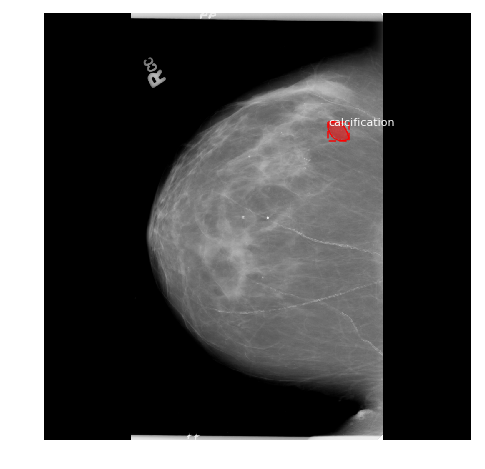

'P_01522_RIGHT_CC.jpg'

In [70]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

output = visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))
# skimage.io.imsave('/data1/share/shiky/Mask_RCNN/test2.jpg', output)
# # 	plt.savefig("/data1/share/shiky/Mask_RCNN/test.jpg")
# # print(output)
# mask, class_ids = dataset_val.load_mask(image_id)


# mask = mask.astype('uint8')


# mask[mask == 1] = 255
# mask = mask[:, :, 0]
# # cv2.imshow('mask',mask)
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()
# plt.figure(figsize=(13,13))
# plt.imshow(mask, cmap='gray')
dataset_val.load_name(image_id)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000


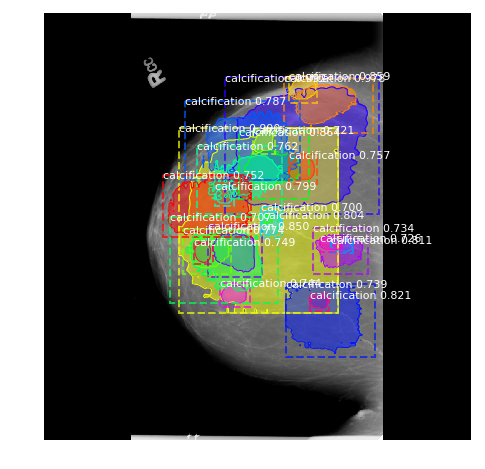

In [71]:
results = model.detect([original_image], verbose=1)
r = results[0]

visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [73]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 50)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    print(image_id)
#     log("image", image)
#     log("mask", gt_mask)
#     log("class_ids", gt_class_id)
#     log("bbox", gt_bbox)
#     # Display image and instances
#     visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, dataset_val.class_names)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

191


/root/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


187
160
19
34
177
49
98
48
5
100
0
139
40
95
46
24
13
137
103
137
177
64
197
70
149
89
61
105
178
112
108
112
183
95
132
185
20
125
7
81
173
146
33
182
151
34
76
30
65
mAP:  0.060580086580086574


In [3]:
!rm -r /data1/share/shiky/Mask_RCNN/data/logs/*

rm: cannot remove '/data1/share/shiky/Mask_RCNN/data/logs/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0023.h5': No such file or directory


In [3]:
!ls /data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/*

/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0001.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0002.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0003.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0004.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0005.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0006.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0007.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0008.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0009.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0010.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0011.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0012.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcn